In [1]:
import xarray as xr
import numpy as np
import zarr
import dask.array as da

from os import path

import matplotlib.pyplot as plt

import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.models import Sequential
# from keras.layers import MaxPooling2D, BatchNormalization, Conv2D, Dropout, UpSampling2D, concatenate, Conv2DTranspose
import keras.layers as layers
from keras import Input

import calendar
import cartopy.crs as ccrs
import cartopy.feature as cfeature

2024-08-06 16:53:05.949664: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# list all the physical devices
physical_devices = tf.config.list_physical_devices()
print("All Physical Devices:", physical_devices)

# list all the available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

# Print infomation for available GPU if there exists any
if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print("GPU Details:", details)
else:
    print("No GPU available")

All Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Details: {'compute_capability': (7, 5), 'device_name': 'Tesla T4'}


In [3]:
zarr_path = "../shared/data/IO.zarr"
zarr_ds = xr.open_zarr(store=zarr_path, consolidated=True)  # get data

# zarr_reg_slice = zarr_ds.sel(lat=slice(35, -5.25), lon=slice(45,79.75))  # choose long and lat
zarr_ds = zarr_ds.sel(lat=slice(32, -11.75), lon=slice(42,101.75))

all_nan_CHL = np.isnan(zarr_ds['CHL_cmes-level3']).all(dim=["lon", "lat"]).compute()  # find sample indices where CHL is NaN

zarr_ds = zarr_ds.sel(time=(~all_nan_CHL))  # select samples with CHL not NaN

zarr_ds = zarr_ds.sortby('time')

In [4]:
def unstdize(stdized_image, mean, stdev):
    return stdized_image * stdev + mean

def compute_mae(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return np.mean(np.abs(y_true[mask] - y_pred[mask]))

def compute_mse(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return np.mean((y_true[mask] - y_pred[mask]) ** 2)

def mean_error(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return np.abs(np.mean(y_true[mask]) - np.mean(y_pred[mask]))

In [40]:
def save_predictions(zarr_label, model, model_name):
    zarr_stdized = xr.open_zarr(zarr.DirectoryStore(f'data/{zarr_label}.zarr'))
    mean_std = np.load(f'data/{zarr_label}.npy',allow_pickle='TRUE').item()
    mean, std = mean_std['CHL'][0], mean_std['CHL'][1]
    # zarr_date = zarr_stdized.sel(time=date_to_predict)

    # predicting observed
    print('predicting observed...')
    predicted_CHL_obs = []
    for year in range(1997, 2023):
        zarr_yr = zarr_stdized.sel(time=str(year))
        X = []
        X_vars = list(zarr_stdized.keys())
        X_vars.remove('CHL')
        for var in X_vars:
            var = zarr_yr[var].to_numpy()
            X.append(np.where(np.isnan(var), 0.0, var))
        X = np.array(X)
        X = np.moveaxis(X, 0, -1)

        # np.where(zarr_ds['CHL_cmes-cloud'][0] == 2, np.nan, zarr_pred.gapfree_pred[3000])
        predicted_CHL = model.predict(X, verbose=0)
        predicted_CHL = predicted_CHL.reshape(predicted_CHL.shape[:-1])
        predicted_CHL = unstdize(predicted_CHL, mean, std)
        flag = zarr_yr['CHL']
        predicted_CHL = da.where(da.isnan(flag), np.nan, predicted_CHL)
        # print(predicted_CHL.shape)
        # print(type(predicted_CHL))
        predicted_CHL_obs.append(predicted_CHL)
        print(f'{year} done')
    predicted_CHL_obs = np.vstack(predicted_CHL_obs)
    print('observed prediction done\n')

    # predicting gapfree
    print('predicting gapfree...')
    predicted_CHL_gapfree = []
    for year in range(1997, 2023):
        zarr_yr = zarr_stdized.sel(time=str(year))
        X = []
        X_vars = list(zarr_stdized.keys())
        X_vars.remove('CHL')
        X_vars[X_vars.index('masked_CHL')] = 'CHL'
        X_vars[X_vars.index('real_cloud_flag')] = 'a'
        X_vars[X_vars.index('fake_cloud_flag')] = 'real_cloud_flag'
        X_vars[X_vars.index('a')] = 'fake_cloud_flag'
        for var in X_vars:
            var = zarr_yr[var].to_numpy()
            X.append(np.where(np.isnan(var), 0.0, var))
        valid_CHL_ind = X_vars.index('valid_CHL_flag')
        X[valid_CHL_ind] = da.where(X[X_vars.index('fake_cloud_flag')] == 1, 1, X[valid_CHL_ind]) 
        X[X_vars.index('fake_cloud_flag')] = np.zeros(X[0].shape)
        X_masked_CHL = np.log(zarr_ds['CHL_cmes-level3'].to_numpy())
        X_masked_CHL = (X_masked_CHL - da.full(X_masked_CHL.shape, mean_std['masked_CHL'][0])) / da.full(X_masked_CHL.shape, mean_std['masked_CHL'][1])
        X_vars[X_vars.index('CHL')] = np.where(np.isnan(X_masked_CHL), 0.0, X_masked_CHL)
        X = np.array(X)
        X = np.moveaxis(X, 0, -1)

        predicted_CHL = model.predict(X, verbose=0)
        predicted_CHL = predicted_CHL.reshape(predicted_CHL.shape[:-1])
        predicted_CHL = unstdize(predicted_CHL, mean, std)
        flag = zarr_yr['land_flag']
        predicted_CHL = da.where(flag == 1, np.nan, predicted_CHL)
        predicted_CHL_gapfree.append(predicted_CHL)
        print(f'{year} done')
    predicted_CHL_gapfree = np.vstack(predicted_CHL_gapfree)

    # create zarr
    chunk_size = 100
    coord_names = ['time', 'lat', 'lon']
    coords = {coord_name: zarr_ds[coord_name] for coord_name in coord_names}
    var_names = ['level3_pred', 'gapfree_pred']
    features = [predicted_CHL_obs, predicted_CHL_gapfree]
    
    dict = {var_name: (coord_names, feature) for var_name, feature in zip(var_names, features)}
    print('variables dicts loaded')
    
    ds = xr.Dataset(dict, coords=coords)
    print('xarray datasets created')    

    for var in list(ds.keys()):
        ds[var]=ds[var].chunk({"time": chunk_size}) 
    print('chunked')

    store = zarr.DirectoryStore(f'../shared/yifei_data/{model_name}_pred.zarr')
    # ds.to_zarr(store, mode='w')
    ds.to_zarr(store, mode='w')
    # xr.open_zarr(store)

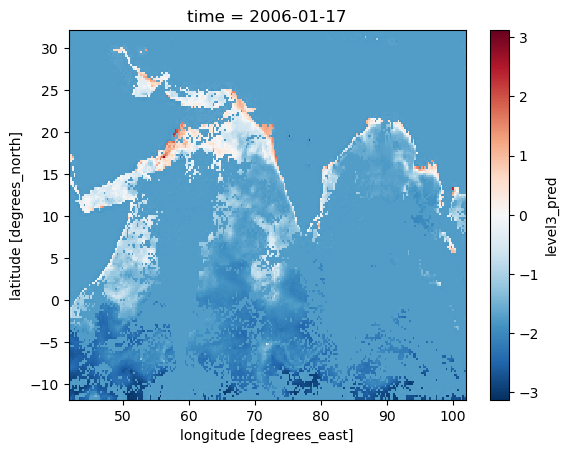

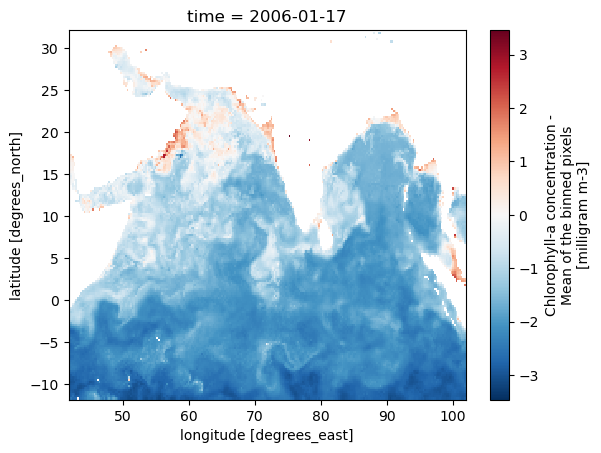

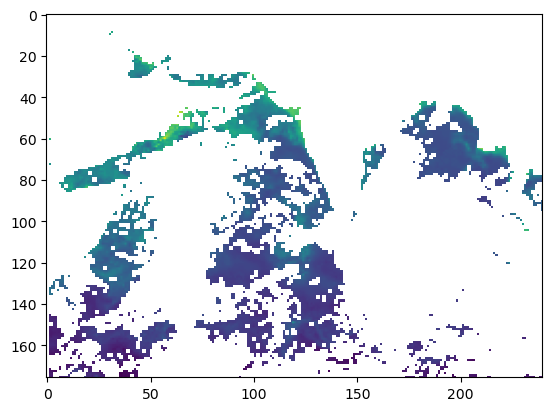

In [41]:
zarr_pred = xr.open_zarr(zarr.DirectoryStore(f'data/{'U-Net_with_CHL_pred'}.zarr'))
zarr_pred.level3_pred[3000].plot()
plt.show()
np.log(zarr_ds['CHL_cmes-gapfree'][3000]).plot()
plt.show()
        # predicted_CHL = da.where(flag == 0, np.nan, predicted_CHL)
zarr_stdized = xr.open_zarr(zarr.DirectoryStore(f'data/{zarr_label}.zarr'))

a = np.where(np.isnan(zarr_stdized['CHL'][3000]), np.nan, zarr_pred.level3_pred[3000])
# zarr_stdized['CHL'][3000].plot()
plt.imshow(a)

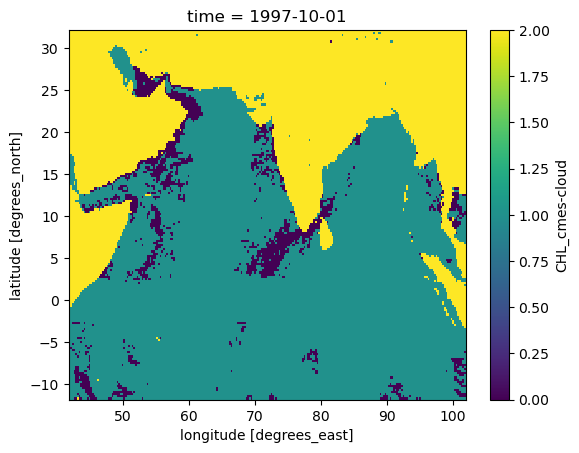

In [42]:
zarr_ds['CHL_cmes-cloud'][0].plot()

In [43]:
zarr_label = '2015_3_full_2days'
model = tf.keras.models.load_model(f'models/{zarr_label}/{'UNet_DoubleConv_mse'}.keras')
model_name = 'U-Net_with_CHL'

save_predictions(zarr_label, model, model_name) 

predicting observed...
1997 done
1998 done
1999 done
2000 done
2001 done
2002 done
2003 done
2004 done
2005 done
2006 done
2007 done
2008 done
2009 done
2010 done
2011 done
2012 done
2013 done
2014 done
2015 done
2016 done
2017 done
2018 done
2019 done
2020 done
2021 done
2022 done
observed prediction done

predicting gapfree...
1997 done
1998 done
1999 done
2000 done
2001 done
2002 done
2003 done
2004 done
2005 done
2006 done
2007 done
2008 done
2009 done
2010 done
2011 done
2012 done
2013 done
2014 done
2015 done
2016 done
2017 done
2018 done
2019 done
2020 done
2021 done
2022 done
variables dicts loaded
xarray datasets created
chunked


In [44]:
def save_predictions_no_CHL(zarr_label, model, model_name):
    zarr_stdized = xr.open_zarr(zarr.DirectoryStore(f'data/{zarr_label}.zarr'))
    mean_std = np.load(f'data/{zarr_label}.npy',allow_pickle='TRUE').item()
    mean, std = mean_std['CHL'][0], mean_std['CHL'][1]
    # zarr_date = zarr_stdized.sel(time=date_to_predict)
    
    # predicting observed
    print('predicting gapfree...')
    predicted_CHL_gapfree = []
    for year in range(1997, 2023):
        zarr_yr = zarr_stdized.sel(time=str(year))
        X = []
        X_vars = list(zarr_stdized.keys())
        X_vars.remove('CHL')
        for var in X_vars:
            var = zarr_yr[var].to_numpy()
            X.append(np.where(np.isnan(var), 0.0, var))
        valid_CHL_ind = X_vars.index('valid_CHL_flag')
        X[valid_CHL_ind] = da.where(X[X_vars.index('real_cloud_flag')] == 1, 1, X[valid_CHL_ind])
        X[X_vars.index('real_cloud_flag')] = np.zeros(X[0].shape)
        X = np.array(X)
        X = np.moveaxis(X, 0, -1)

        predicted_CHL = model.predict(X, verbose=0)
        predicted_CHL = predicted_CHL.reshape(predicted_CHL.shape[:-1])
        predicted_CHL = unstdize(predicted_CHL, mean, std)
        flag = zarr_yr['land_flag']
        predicted_CHL = da.where(flag == 1, np.nan, predicted_CHL)
        predicted_CHL_gapfree.append(predicted_CHL)
        print(f'{year} done')
    predicted_CHL_gapfree = np.vstack(predicted_CHL_gapfree)

    # create zarr
    chunk_size = 100
    coord_names = ['time', 'lat', 'lon']
    coords = {coord_name: zarr_ds[coord_name] for coord_name in coord_names}
    var_names = ['gapfree_pred']
    features = [predicted_CHL_gapfree]
    
    dict = {var_name: (coord_names, feature) for var_name, feature in zip(var_names, features)}
    print('variables dicts loaded')
    
    ds = xr.Dataset(dict, coords=coords)
    print('xarray datasets created')    

    for var in list(ds.keys()):
        ds[var]=ds[var].chunk({"time": chunk_size}) 
    print('chunked')

    store = zarr.DirectoryStore(f'../shared/yifei_data/{model_name}_pred.zarr')
    # ds.to_zarr(store, mode='w')
    ds.to_zarr(store, mode='w')
    # xr.open_zarr(store)

In [45]:
zarr_label = '2011_6_no_CHL'
model = tf.keras.models.load_model(f'models/{zarr_label}/{'UNet_DoubleConv_noCHL'}.keras')
model_name = 'U-Net_without_CHL'

save_predictions_no_CHL(zarr_label, model, model_name) 

predicting gapfree...
1997 done
1998 done
1999 done
2000 done
2001 done
2002 done
2003 done
2004 done
2005 done
2006 done
2007 done
2008 done
2009 done
2010 done
2011 done
2012 done
2013 done
2014 done
2015 done
2016 done
2017 done
2018 done
2019 done
2020 done
2021 done
2022 done
variables dicts loaded
xarray datasets created
chunked


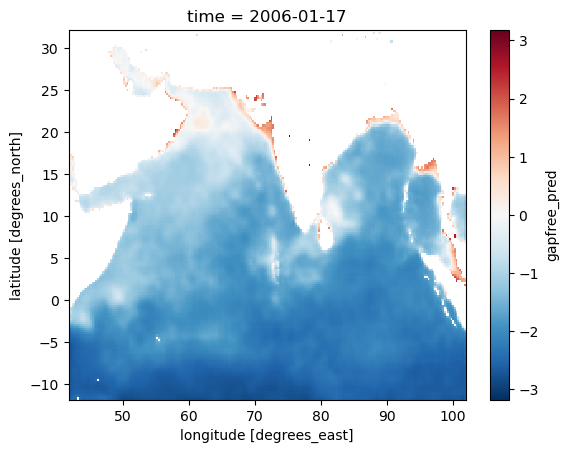

In [48]:
zarr_pred_no_CHL = xr.open_zarr(zarr.DirectoryStore(f'../shared/yifei_data/{'U-Net_without_CHL_pred'}.zarr'))
zarr_pred_no_CHL.gapfree_pred[3000].plot()

In [5]:
zarr_stdized = xr.open_zarr(zarr.DirectoryStore('data/2015_3_full_2days.zarr'))

In [44]:
# plots: observed, flag, predict, diff
def cross_val(zarr_stdized, date):
    zarr_pred = xr.open_zarr(zarr.DirectoryStore(f'../shared/yifei_data/{'U-Net_with_CHL_pred'}.zarr'))
    true_CHL = np.log(zarr_ds.sel(time=date)['CHL_cmes-level3'].to_numpy())
    flag = np.zeros(true_CHL.shape)
    flag = np.where(zarr_stdized.sel(time=date)['land_flag'] == 1, 0, flag)
    flag = np.where(zarr_stdized.sel(time=date)['valid_CHL_flag'] == 1, 2, flag)
    flag = np.where(zarr_stdized.sel(time=date)['real_cloud_flag'] == 1, 0, flag)
    flag = np.where(zarr_stdized.sel(time=date)['fake_cloud_flag'] == 1, 1, flag)
    predicted_CHL = zarr_pred.sel(time=date)['level3_pred'].to_numpy()
    diff = true_CHL - predicted_CHL

    vmax = np.nanmax((true_CHL, predicted_CHL))
    vmin = np.nanmin((true_CHL, predicted_CHL))

    extent = [42, 101.75, -11.75, 32]
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    im0 = axes[0, 0].imshow(true_CHL, vmin=vmin, vmax=vmax, extent=extent, origin='upper', transform=ccrs.PlateCarree(), interpolation='nearest')
    axes[0, 0].add_feature(cfeature.COASTLINE)
    axes[0, 0].set_xlabel('longitude')
    axes[0, 0].set_ylabel('latitude')
    axes[0, 0].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[0, 0].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[0, 0].set_title('Observed Level-3 log Chl-a', size=14)
    im1 = axes[0, 1].imshow(flag, extent=extent, origin='upper', transform=ccrs.PlateCarree())
    # im = axes[0, 1].imshow(true_CHL, vmin=vmin, vmax=vmax, alpha=0.3)  #
    axes[0, 1].add_feature(cfeature.COASTLINE, color='white')
    axes[0, 1].set_xlabel('longitude')
    axes[0, 1].set_ylabel('latitude')
    axes[0, 1].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[0, 1].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[0, 1].set_title('Land, Cloud, and Observed Flags After Applying Fake Cloud', size=13)
    im2 = axes[1, 0].imshow(predicted_CHL, vmin=vmin, vmax=vmax, extent=extent, origin='upper', transform=ccrs.PlateCarree(), interpolation='nearest') 
    axes[1, 0].add_feature(cfeature.COASTLINE, color='white')
    axes[1, 0].imshow(np.where(flag == 1, np.nan, flag), vmax=2, vmin=0, extent=extent, origin='upper', interpolation='nearest', alpha=1)
    
    axes[1, 0].set_xlabel('longitude')
    axes[1, 0].set_ylabel('latitude')
    axes[1, 0].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[1, 0].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[1, 0].set_title('Predicted log Chl-a from U-Net', size=14)

    vmin2 = np.nanmin(diff)
    vmax2 = np.nanmax(diff)
    vmax2 = np.nanmax((np.abs(vmin2), np.abs(vmax2)))
    vmin2 = -vmax2
    vmin2 = -1
    vmax2 = 1
    im3 = axes[1, 1].imshow(diff, vmin=vmin2, vmax=vmax2, extent=extent, origin='upper', transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu, interpolation='nearest')
    axes[1, 1].add_feature(cfeature.COASTLINE)
    axes[1, 1].set_xlabel('longitude')
    axes[1, 1].set_ylabel('latitude')
    axes[1, 1].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[1, 1].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[1, 1].set_title('Difference Between log Observed and log Prediction\n(log observed - log prediction)', size=13)

    # fig.subplots_adjust(right=0.85)
    # cbar_ax = fig.add_axes([0.88, 0.2, 0.03, 0.6])
    # fig.colorbar(im, cax=cbar_ax)

    # cbar2_ax = fig.add_axes([0.95, 0.2, 0.03, 0.6])
    # fig.colorbar(im2, cax=cbar2_ax)

    fig.subplots_adjust(right=0.76)
    cbar1_ax = fig.add_axes([0.79, 0.14, 0.025, 0.72])
    # .ax.set_ylabel('# of contacts', rotation=270)
    cbar1 = fig.colorbar(im0, cax=cbar1_ax)
    cbar1.ax.set_ylabel('log Chl-a (mg/m-3)', rotation=270, size=14, labelpad=16)

    cbar2_ax = fig.add_axes([0.86, 0.14, 0.025, 0.72])
    # .ax.set_ylabel('# of contacts', rotation=270)
    cbar2 = fig.colorbar(im1, cax=cbar2_ax)
    cbar2.ax.set_ylabel('land and real cloud = 0, fake cloud = 1, observed after masking = 2', rotation=270, size=14, labelpad=20)

    cbar3_ax = fig.add_axes([0.94, 0.14, 0.025, 0.72])
    # .ax.set_ylabel('# of contacts', rotation=270)
    cbar3 = fig.colorbar(im3, cax=cbar3_ax)
    cbar3.ax.set_ylabel('difference in log Chl-a', rotation=270, size=14, labelpad=16)
    plt.show()

/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


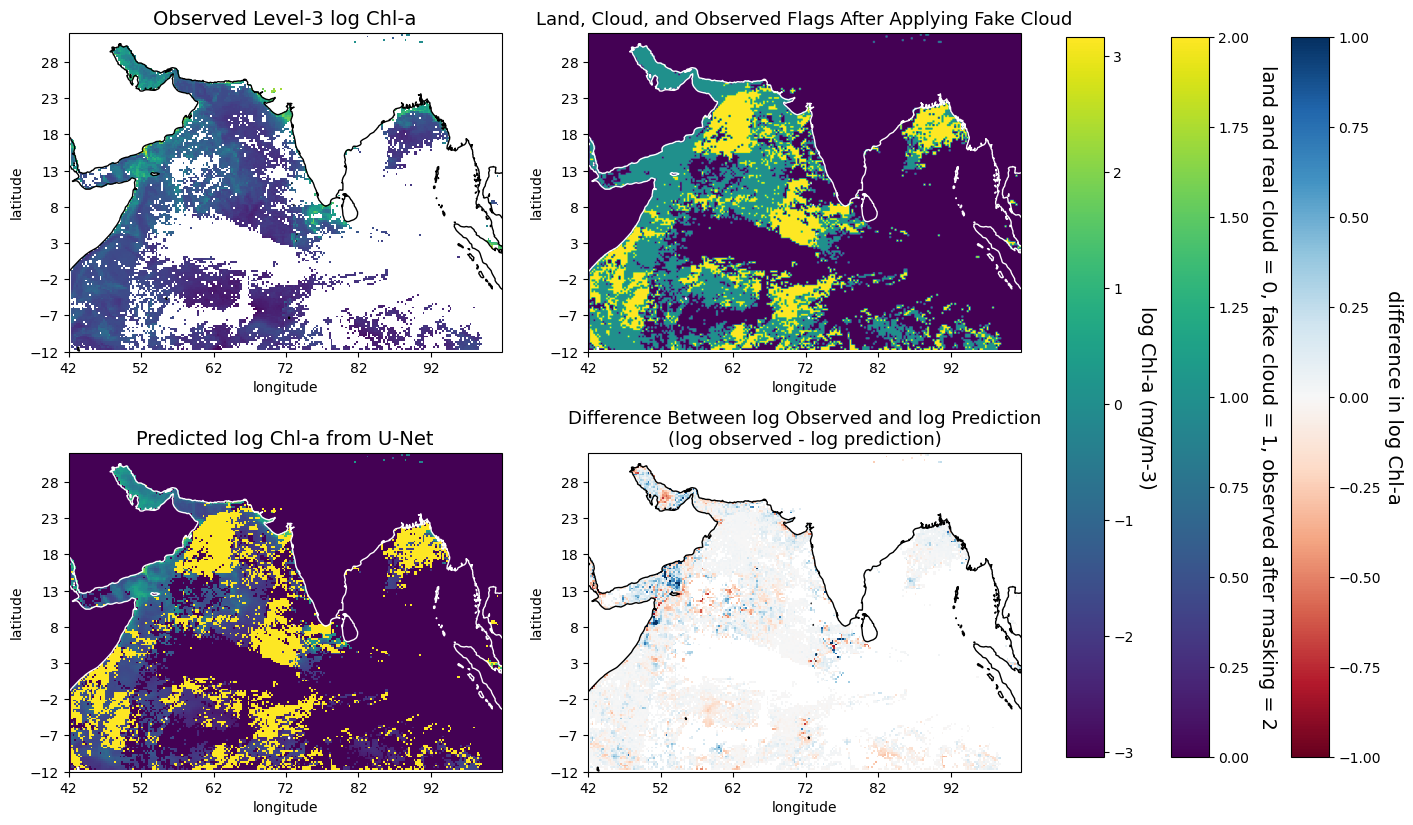

In [54]:
cross_val(zarr_stdized, '2020-10-08')

In [47]:
def get_cloud_perc(zarr_stdized, year):
    zarr_time_range = zarr_stdized.sel(time=str(year))

    non_land_cnt = len(np.where(zarr_time_range['land_flag'][0] == 0)[0])
    clouds = zarr_time_range['real_cloud_flag'].data
    cloud_cnt = np.sum(clouds == 1, axis=(1, 2)).compute()
    cloud_perc = cloud_cnt / non_land_cnt

    return cloud_perc

In [50]:
def get_cloud_perc_val(zarr_stdized, year):
    zarr_time_range = zarr_stdized.sel(time=str(year))
    CHL = zarr_time_range['CHL'].data
    CHL_cnt =  np.sum(~np.isnan(CHL), axis=(1, 2)).compute()
    clouds = zarr_time_range['fake_cloud_flag'].data
    cloud_cnt = np.sum(clouds == 1, axis=(1, 2)).compute()
    cloud_perc = cloud_cnt / CHL_cnt

    return cloud_perc


In [51]:
def cross_val_loss_vs_cloud_perc_plot(zarr_stdized, year):
    zarr_pred = xr.open_zarr(zarr.DirectoryStore(f'../shared/yifei_data/{'U-Net_with_CHL_pred'}.zarr'))
    true_CHL = np.log(zarr_ds.sel(time=str(year))['CHL_cmes-level3'].to_numpy())
    predicted_CHL = zarr_pred.sel(time=str(year))['level3_pred'].to_numpy()
    flag = zarr_stdized.sel(time=str(year))['valid_CHL_flag'].to_numpy()
    predicted_CHL = np.where(flag == 1, np.nan, predicted_CHL)
    losses = []
    for true, pred in zip(true_CHL, predicted_CHL):
        losses.append(compute_mae(true, pred))
    cloud_perc = get_cloud_perc_val(zarr_stdized, year)
    
    fig, ax1 = plt.subplots()
    
    color = 'tab:red'
    ax1.set_xlabel('Month')
    ax1.set_ylabel('MAD of log (Globcolour l3) - log (U-Net)', color=color)
    ax1.plot(losses, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
    
    color = 'tab:blue'
    ax2.set_ylabel('Cloud Percentage', color=color)  # we already handled the x-label with ax1
    ax2.plot(cloud_perc, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    tick_pos = []
    tick_label = []
    total_day = 1
    tick_pos.append(total_day + 15)
    tick_label.append('1')
    for month in range(1, 12):
        total_day += calendar.monthrange(year, month)[1]
        plt.axvline(total_day, color='grey', alpha=0.3)
        tick_pos.append(total_day + 15)
        tick_label.append(str(month+1))
    plt.title(f'Observed (Level-3) CHL vs U-Net Predictions\nMAD vs Cloud Percentage Year {year}')
    plt.xlim(1, len(losses))
    plt.xticks(tick_pos, tick_label)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()


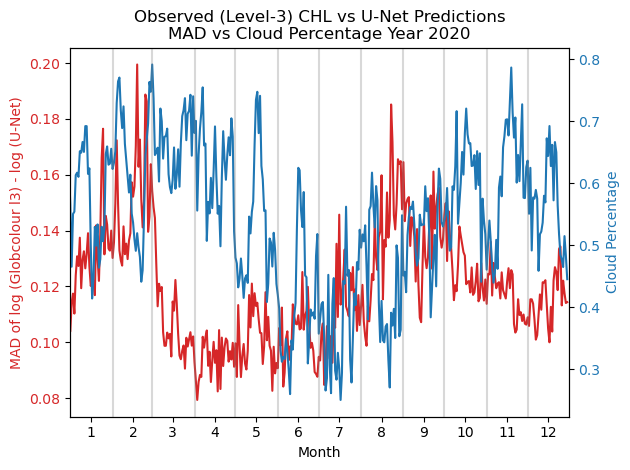

In [52]:
cross_val_loss_vs_cloud_perc_plot(zarr_stdized, 2020)

In [67]:
# plots: observed, predict, log_diff, diff
def compare_to_cmes(zarr_stdized, date):
    zarr_pred = xr.open_zarr(zarr.DirectoryStore(f'../shared/yifei_data/{'U-Net_with_CHL_pred'}.zarr'))
    true_CHL = np.log(zarr_ds.sel(time=date)['CHL_cmes-gapfree'].to_numpy())
    predicted_CHL = zarr_pred.sel(time=date)['gapfree_pred'].to_numpy()
    log_diff = true_CHL - predicted_CHL
    diff = np.exp(true_CHL) - np.exp(predicted_CHL)

    vmax = np.nanmax((true_CHL, predicted_CHL))
    vmin = np.nanmin((true_CHL, predicted_CHL))

    extent = [42, 101.75, -11.75, 32]
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    im0 = axes[0, 0].imshow(true_CHL, vmin=vmin, vmax=vmax, extent=extent, origin='upper', transform=ccrs.PlateCarree())
    # axes[0, 0].add_feature(cfeature.COASTLINE)
    axes[0, 0].set_xlabel('longitude')
    axes[0, 0].set_ylabel('latitude')
    axes[0, 0].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[0, 0].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[0, 0].set_title('Log Chl-a from the Gapfree \nLevel-4 GlobColour Copernicus Product', size=14)
    im1 = axes[0, 1].imshow(predicted_CHL, extent=extent, origin='upper', transform=ccrs.PlateCarree())
    # im = axes[0, 1].imshow(true_CHL, vmin=vmin, vmax=vmax, alpha=0.3)  #
    # axes[0, 1].add_feature(cfeature.COASTLINE)
    axes[0, 1].set_xlabel('longitude')
    axes[0, 1].set_ylabel('latitude')
    axes[0, 1].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[0, 1].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[0, 1].set_title('Gapfree log Chl-a from U-Net', size=14)
    

    vmin2 = np.nanmin(log_diff)
    vmax2 = np.nanmax(log_diff)
    vmax2 = np.nanmax((np.abs(vmin2), np.abs(vmax2)))
    vmin2 = -vmax2
    vmax2 = 1
    vmin2 = -1
    im2 = axes[1, 0].imshow(log_diff, vmin=vmin2, vmax=vmax2, extent=extent, origin='upper', transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu)
    # axes[1, 0].add_feature(cfeature.COASTLINE)
    axes[1, 0].set_xlabel('longitude')
    axes[1, 0].set_ylabel('latitude')
    axes[1, 0].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[1, 0].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[1, 0].set_title('Difference Between log Copernicus Product\nand log U-Net Prediction(log Copernicus - log U-Net)', size=13)

    vmin3 = np.nanmin(diff)
    vmax3 = np.nanmax(diff)
    vmax3 = np.nanmax((np.abs(vmin3), np.abs(vmax3)))
    vmin3 = -vmax3
    vmax3 = 1
    vmin3 = -1
    im3 = axes[1, 1].imshow(diff, vmin=vmin3, vmax=vmax3, extent=extent, origin='upper', transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu)
    # axes[1, 1].add_feature(cfeature.COASTLINE)
    axes[1, 1].set_xlabel('longitude')
    axes[1, 1].set_ylabel('latitude')
    axes[1, 1].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[1, 1].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[1, 1].set_title('Absolute Difference Between Copernicus Product\nand U-Net Predictions(Copernicus - U-Net)', size=13)

    # fig.subplots_adjust(right=0.85)
    # cbar_ax = fig.add_axes([0.88, 0.2, 0.03, 0.6])
    # fig.colorbar(im, cax=cbar_ax)

    # cbar2_ax = fig.add_axes([0.95, 0.2, 0.03, 0.6])
    # fig.colorbar(im2, cax=cbar2_ax)

    fig.subplots_adjust(right=0.85)
    cbar1_ax = fig.add_axes([0.87, 0.14, 0.025, 0.72])
    # .ax.set_ylabel('# of contacts', rotation=270)
    cbar1 = fig.colorbar(im0, cax=cbar1_ax)
    cbar1.ax.set_ylabel('log Chl-a (mg/m-3)', rotation=270, size=14, labelpad=16)

    cbar2_ax = fig.add_axes([0.94, 0.14, 0.025, 0.72])
    # .ax.set_ylabel('# of contacts', rotation=270)
    cbar2 = fig.colorbar(im2, cax=cbar2_ax)
    cbar2.ax.set_ylabel('difference in Chl-a in log or absolute scales', rotation=270, size=14, labelpad=16)
    plt.subplots_adjust(top=0.96)
    plt.show()

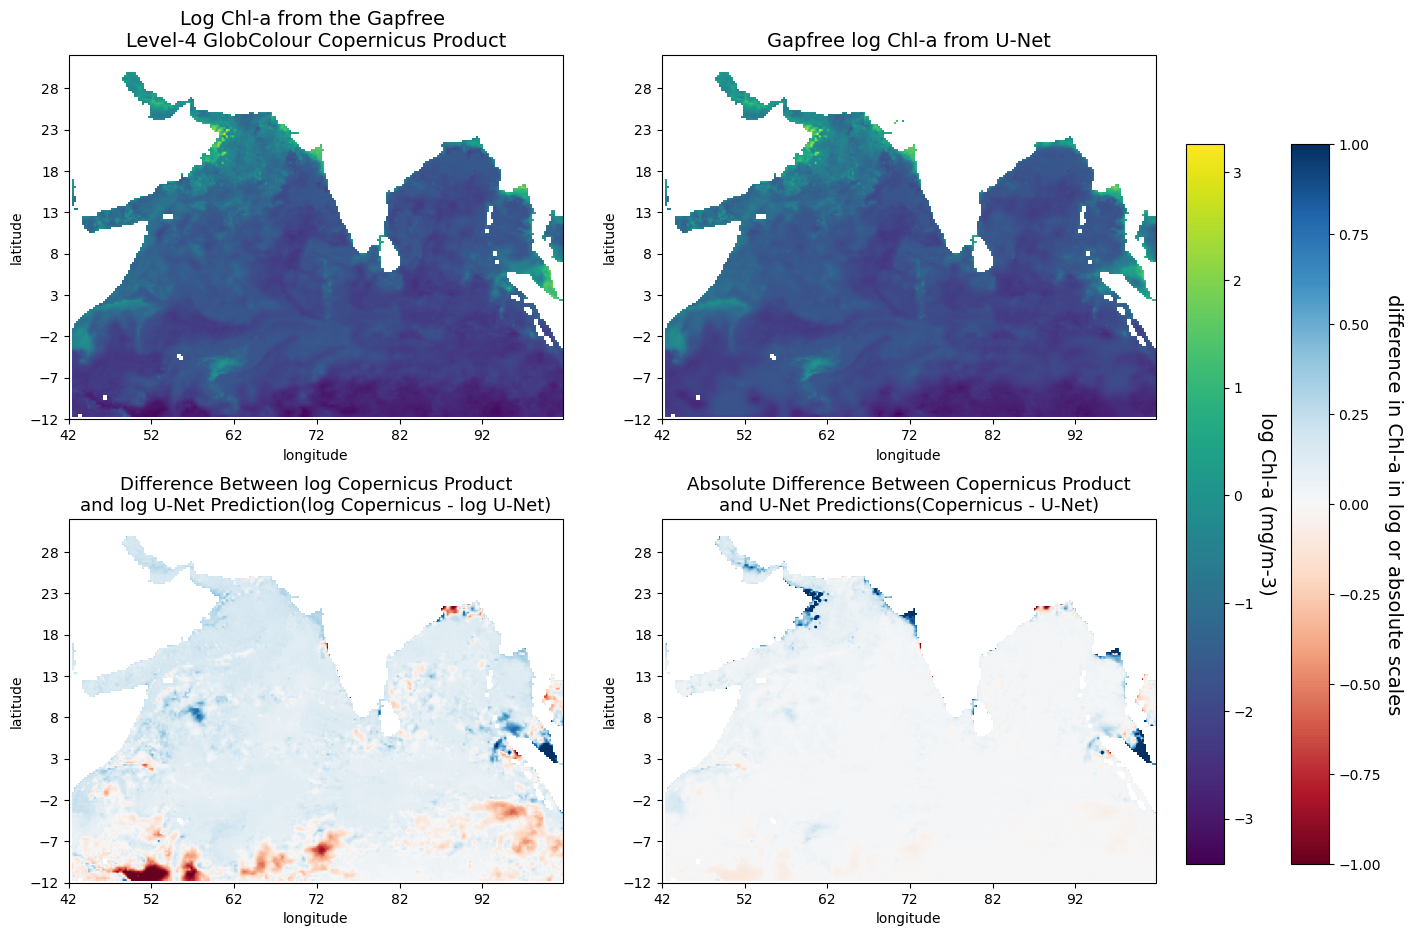

In [107]:
compare_to_cmes(zarr_stdized, '2021-01-19')

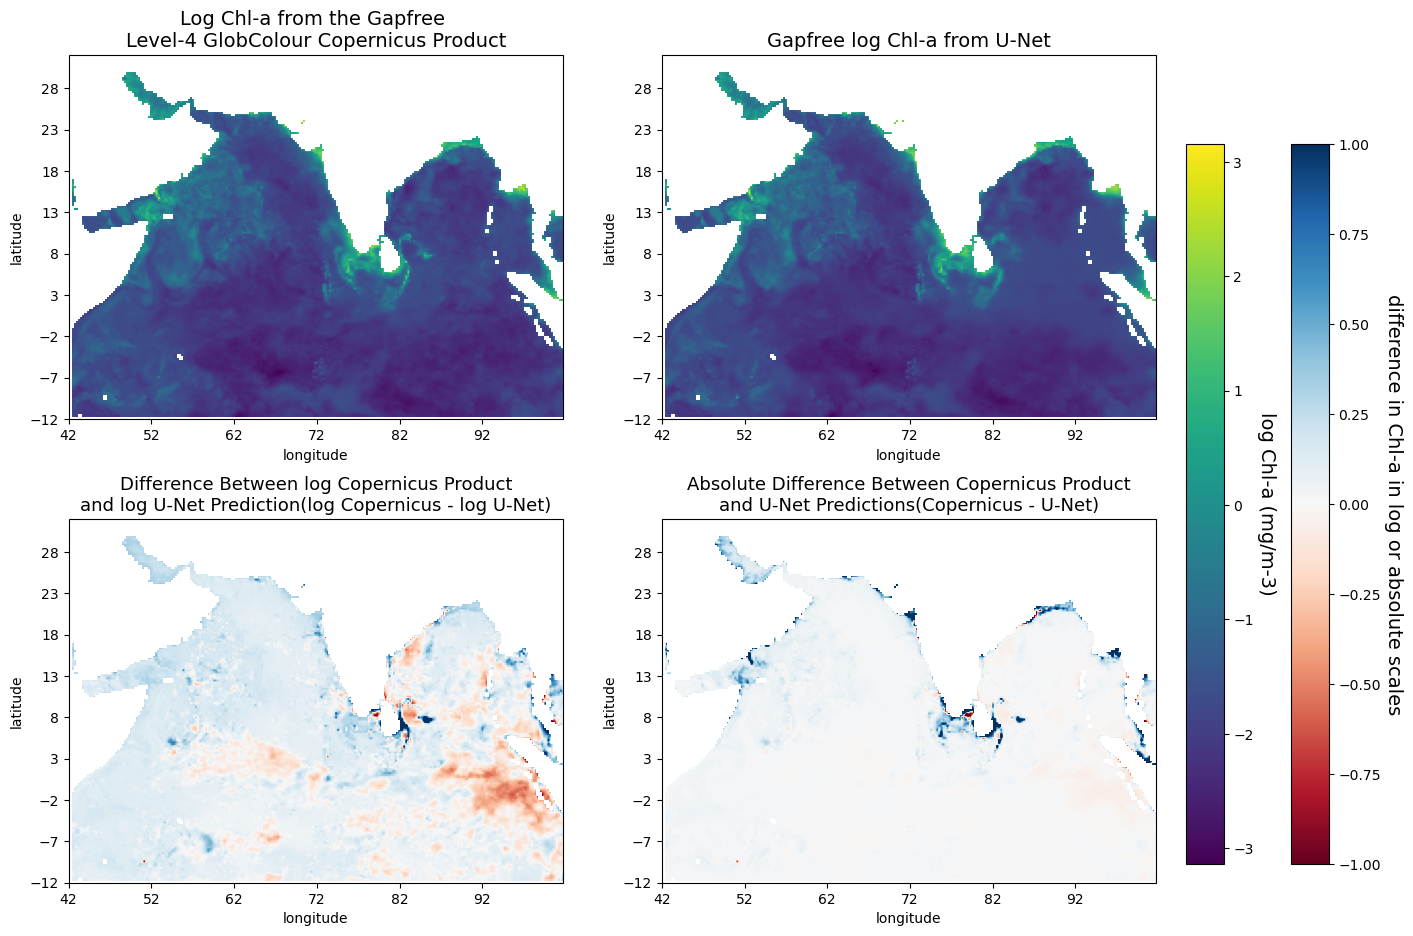

In [108]:
compare_to_cmes(zarr_stdized, '2020-10-08')

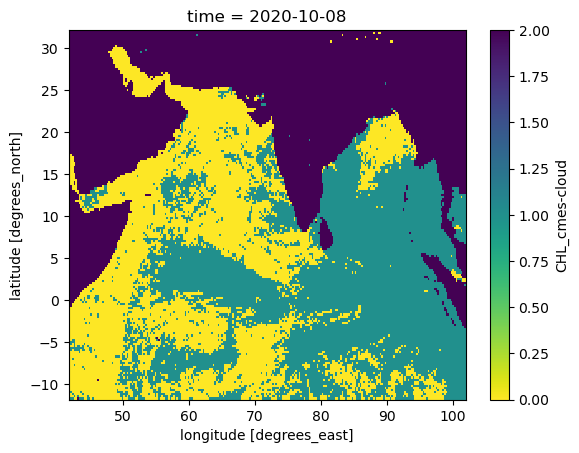

In [123]:
zarr_ds['CHL_cmes-cloud'].sel(time='2020-10-08').plot(cmap='viridis_r')

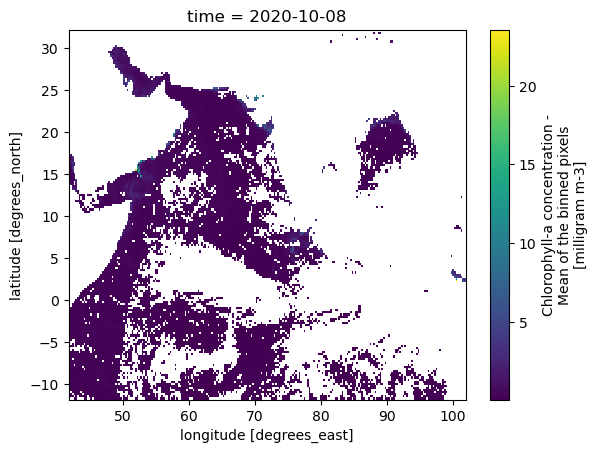

In [124]:
zarr_ds['CHL_cmes-level3'].sel(time='2020-10-08').plot()

In [238]:
def comp_to_cmes_loss_vs_cloud_perc_plot(year):
    zarr_pred = xr.open_zarr(zarr.DirectoryStore(f'../shared/yifei_data/{'U-Net_with_CHL_pred'}.zarr'))
    true_CHL = np.log(zarr_ds.sel(time=str(year))['CHL_cmes-gapfree'].to_numpy())
    predicted_CHL = zarr_pred.sel(time=str(year))['gapfree_pred'].to_numpy()
    flag = zarr_ds.sel(time=str(year))['CHL_cmes-level3'].to_numpy()
    predicted_CHL = np.where(flag == 1, np.nan, predicted_CHL)
    losses = []
    for true, pred in zip(true_CHL, predicted_CHL):
        losses.append(compute_mae(true, pred))
    cloud_perc = get_cloud_perc(zarr_stdized, year)
    
    fig, ax1 = plt.subplots()
    
    color = 'tab:red'
    ax1.set_xlabel('Month')
    ax1.set_ylabel('MAD of log (Globcolour l4) - log (U-Net)', color=color)
    ax1.plot(losses, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
    
    color = 'tab:blue'
    ax2.set_ylabel('Cloud Percentage', color=color)  # we already handled the x-label with ax1
    ax2.plot(cloud_perc, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    tick_pos = []
    tick_label = []
    total_day = 1
    tick_pos.append(total_day + 15)
    tick_label.append('1')
    for month in range(1, 12):
        total_day += calendar.monthrange(year, month)[1]
        plt.axvline(total_day, color='grey', alpha=0.3)
        tick_pos.append(total_day + 15)
        tick_label.append(str(month+1))
    plt.title(f'Copernicus GlobColour Gapfree CHL vs U-Net Predictions\nMAD vs Cloud Percentage Year {year}')
    plt.xlim(1, len(losses))
    plt.xticks(tick_pos, tick_label)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()


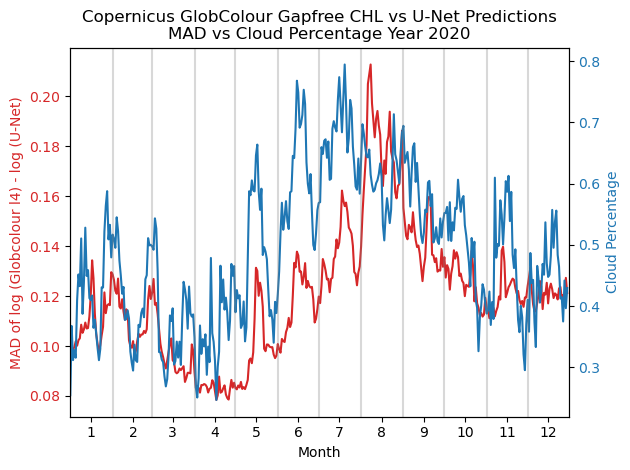

In [239]:
comp_to_cmes_loss_vs_cloud_perc_plot(2020)

In [82]:
def comp_UNets_loss(year):
    zarr_pred_CHL = xr.open_zarr(zarr.DirectoryStore(f'../shared/yifei_data/{'U-Net_with_CHL_pred'}.zarr'))
    zarr_pred_no_CHL = xr.open_zarr(zarr.DirectoryStore(f'../shared/yifei_data/{'U-Net_without_CHL_pred'}.zarr'))
    
    pred_w_CHL = zarr_pred_CHL.sel(time=str(year))['gapfree_pred'].to_numpy()
    pred_no_CHL = zarr_pred_no_CHL.sel(time=str(year))['gapfree_pred'].to_numpy()
    losses = []
    for true, pred in zip(pred_w_CHL, pred_no_CHL):
        losses.append(compute_mae(true, pred))
    
    # fig, ax1 = plt.subplots()
    
    # color = 'tab:red'
    # ax1.set_xlabel('Month')
    # ax1.set_ylabel('MAD of log (Globcolour l4) - log (U-Net)', color=color)
    # ax1.plot(losses, color=color)
    # ax1.tick_params(axis='y', labelcolor=color)
    
    # ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
    
    # color = 'tab:blue'
    # ax2.set_ylabel('Cloud Percentage', color=color)  # we already handled the x-label with ax1
    # ax2.plot(cloud_perc, color=color)
    # ax2.tick_params(axis='y', labelcolor=color)

    plt.plot(losses)
    plt.xlabel('Month')
    plt.ylabel('MAD of log (U-Net w/ CHL) - \nlog (U-Net w/o CHL)')

    tick_pos = []
    tick_label = []
    total_day = 1
    tick_pos.append(total_day + 15)
    tick_label.append('1')
    for month in range(1, 12):
        total_day += calendar.monthrange(year, month)[1]
        plt.axvline(total_day, color='grey', alpha=0.3)
        tick_pos.append(total_day + 15)
        tick_label.append(str(month+1))
    plt.title(f'U-Net Predictions with CHL vs U-Net Predictions without CHL\nMAD Year {year}')
    plt.xlim(1, len(losses))
    plt.xticks(tick_pos, tick_label)
    
    # fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

    max_ind = losses.index(max(losses))
    min_ind = losses.index(min(losses))
    max_date = np.datetime64(f'{year}-01-01') + np.timedelta64(max_ind - 1)
    min_date = np.datetime64(f'{year}-01-01') + np.timedelta64(min_ind - 1)

    return (max_date, min_date)


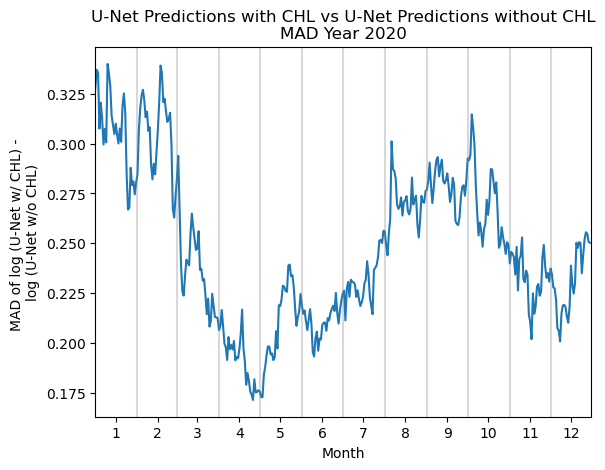

In [83]:
max_date, min_date = comp_UNets_loss(2020)

In [84]:
print(max_date, min_date)

2020-01-10 2020-04-26


In [100]:
# plots: observed, predict, log_diff, diff
def compare_UNet(date):
    zarr_pred_CHL = xr.open_zarr(zarr.DirectoryStore(f'../shared/yifei_data/{'U-Net_with_CHL_pred'}.zarr'))
    zarr_pred_no_CHL = xr.open_zarr(zarr.DirectoryStore(f'../shared/yifei_data/{'U-Net_without_CHL_pred'}.zarr'))
    
    pred_w_CHL = zarr_pred_CHL.sel(time=str(date))['gapfree_pred'].to_numpy()
    pred_no_CHL = zarr_pred_no_CHL.sel(time=str(date))['gapfree_pred'].to_numpy()
    log_diff = pred_w_CHL - pred_no_CHL
    diff = np.exp(pred_w_CHL) - np.exp(pred_no_CHL)

    vmax = np.nanmax((pred_w_CHL, pred_no_CHL))
    vmin = np.nanmin((pred_w_CHL, pred_no_CHL))

    extent = [42, 101.75, -11.75, 32]
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    im0 = axes[0, 0].imshow(pred_w_CHL, vmin=vmin, vmax=vmax, extent=extent, origin='upper', transform=ccrs.PlateCarree())
    # axes[0, 0].add_feature(cfeature.COASTLINE)
    axes[0, 0].set_xlabel('longitude')
    axes[0, 0].set_ylabel('latitude')
    axes[0, 0].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[0, 0].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[0, 0].set_title('Gapfree log Chl-a from U-Net \nIncluding CHL-a Observations', size=14)
    im1 = axes[0, 1].imshow(pred_no_CHL, extent=extent, origin='upper', transform=ccrs.PlateCarree())
    # im = axes[0, 1].imshow(true_CHL, vmin=vmin, vmax=vmax, alpha=0.3)  #
    # axes[0, 1].add_feature(cfeature.COASTLINE)
    axes[0, 1].set_xlabel('longitude')
    axes[0, 1].set_ylabel('latitude')
    axes[0, 1].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[0, 1].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[0, 1].set_title('Gapfree log Chl-a from U-Net \nwith Only Wind, SST, Air Temp, and Time', size=14)
    

    vmin2 = np.nanmin(log_diff)
    vmax2 = np.nanmax(log_diff)
    vmax2 = np.nanmax((np.abs(vmin2), np.abs(vmax2)))
    vmin2 = -vmax2
    vmin2 = -1
    vmax2 = 1
    im2 = axes[1, 0].imshow(log_diff, vmin=vmin2, vmax=vmax2, extent=extent, origin='upper', transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu)
    # axes[1, 0].add_feature(cfeature.COASTLINE)
    axes[1, 0].set_xlabel('longitude')
    axes[1, 0].set_ylabel('latitude')
    axes[1, 0].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[1, 0].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[1, 0].set_title('Difference Between\nlog U-Net with CHL and log U-Net without CHL\n(log U-Net with CHL - log U-Net without CHL)', size=13)

    vmin3 = np.nanmin(diff)
    vmax3 = np.nanmax(diff)
    vmax3 = np.nanmax((np.abs(vmin3), np.abs(vmax3)))
    vmin3 = -vmax3
    vmin3 = -1
    vmax3 = 1
    im3 = axes[1, 1].imshow(diff, vmin=vmin3, vmax=vmax3, extent=extent, origin='upper', transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu)
    # axes[1, 1].add_feature(cfeature.COASTLINE)
    axes[1, 1].set_xlabel('longitude')
    axes[1, 1].set_ylabel('latitude')
    axes[1, 1].set_xticks(np.arange(42, 102, 10), crs=ccrs.PlateCarree())
    axes[1, 1].set_yticks(np.arange(-12, 32, 5), crs=ccrs.PlateCarree())
    axes[1, 1].set_title('Absolute Difference Between\nU-Net with CHL and U-Net without CHL\n(U-Net with CHL - U-Net without CHL)', size=13)

    # fig.subplots_adjust(right=0.85)
    # cbar_ax = fig.add_axes([0.88, 0.2, 0.03, 0.6])
    # fig.colorbar(im, cax=cbar_ax)

    # cbar2_ax = fig.add_axes([0.95, 0.2, 0.03, 0.6])
    # fig.colorbar(im2, cax=cbar2_ax)

    fig.subplots_adjust(right=0.85)
    cbar1_ax = fig.add_axes([0.87, 0.14, 0.025, 0.72])
    # .ax.set_ylabel('# of contacts', rotation=270)
    cbar1 = fig.colorbar(im0, cax=cbar1_ax)
    cbar1.ax.set_ylabel('log Chl-a (mg/m-3)', rotation=270, size=14, labelpad=16)

    cbar2_ax = fig.add_axes([0.94, 0.14, 0.025, 0.72])
    # .ax.set_ylabel('# of contacts', rotation=270)
    cbar2 = fig.colorbar(im2, cax=cbar2_ax)
    cbar2.ax.set_ylabel('difference in log Chl-a', rotation=270, size=14, labelpad=16)

    plt.subplots_adjust(top=0.94, bottom=0.06)
    plt.show()

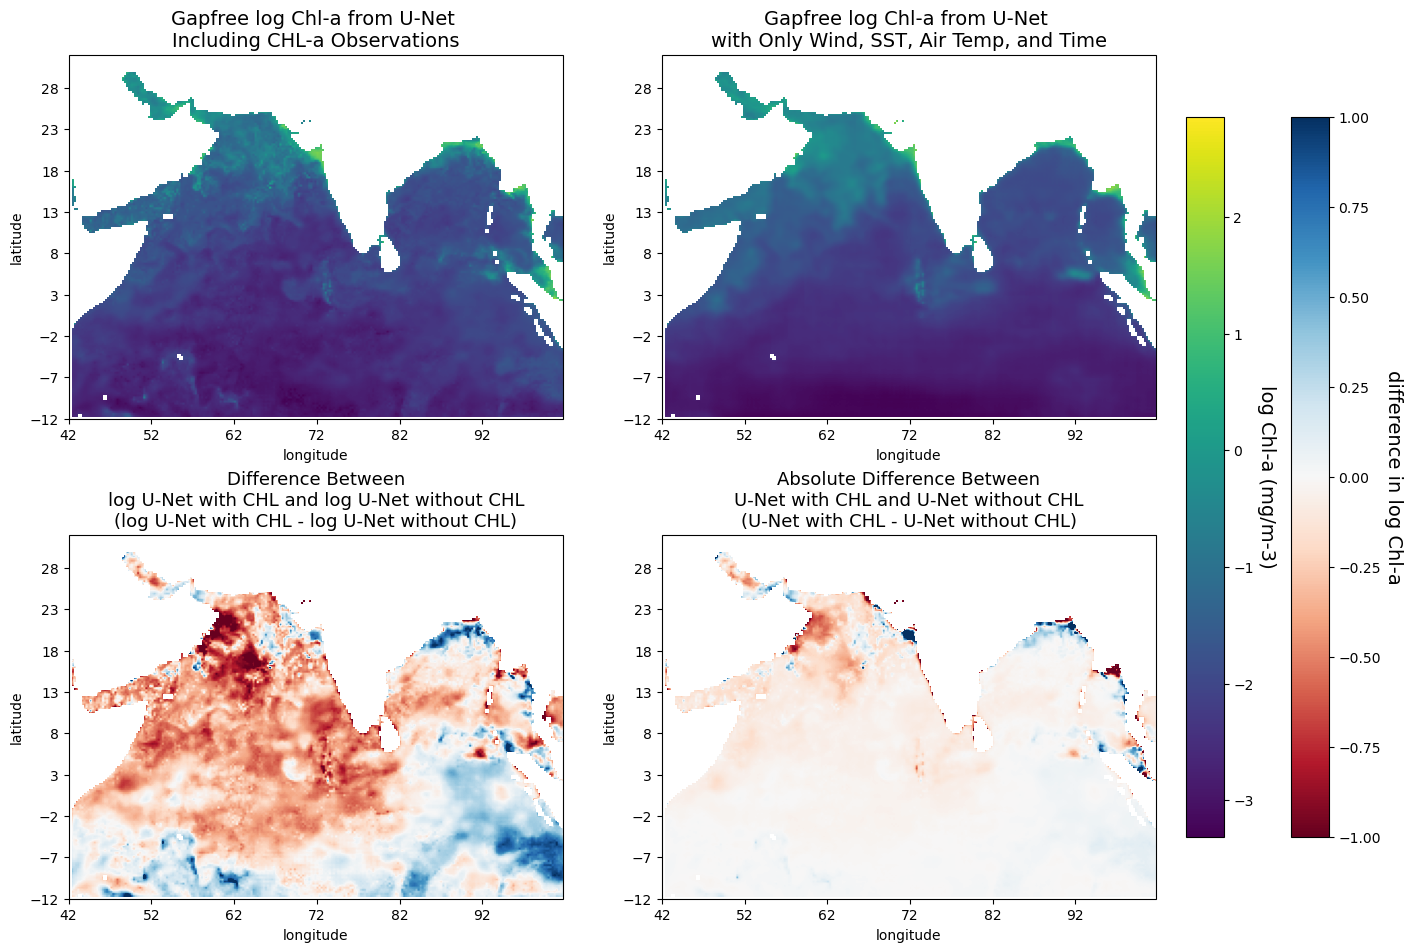

2020-01-10


In [101]:
compare_UNet(max_date)
print(max_date)

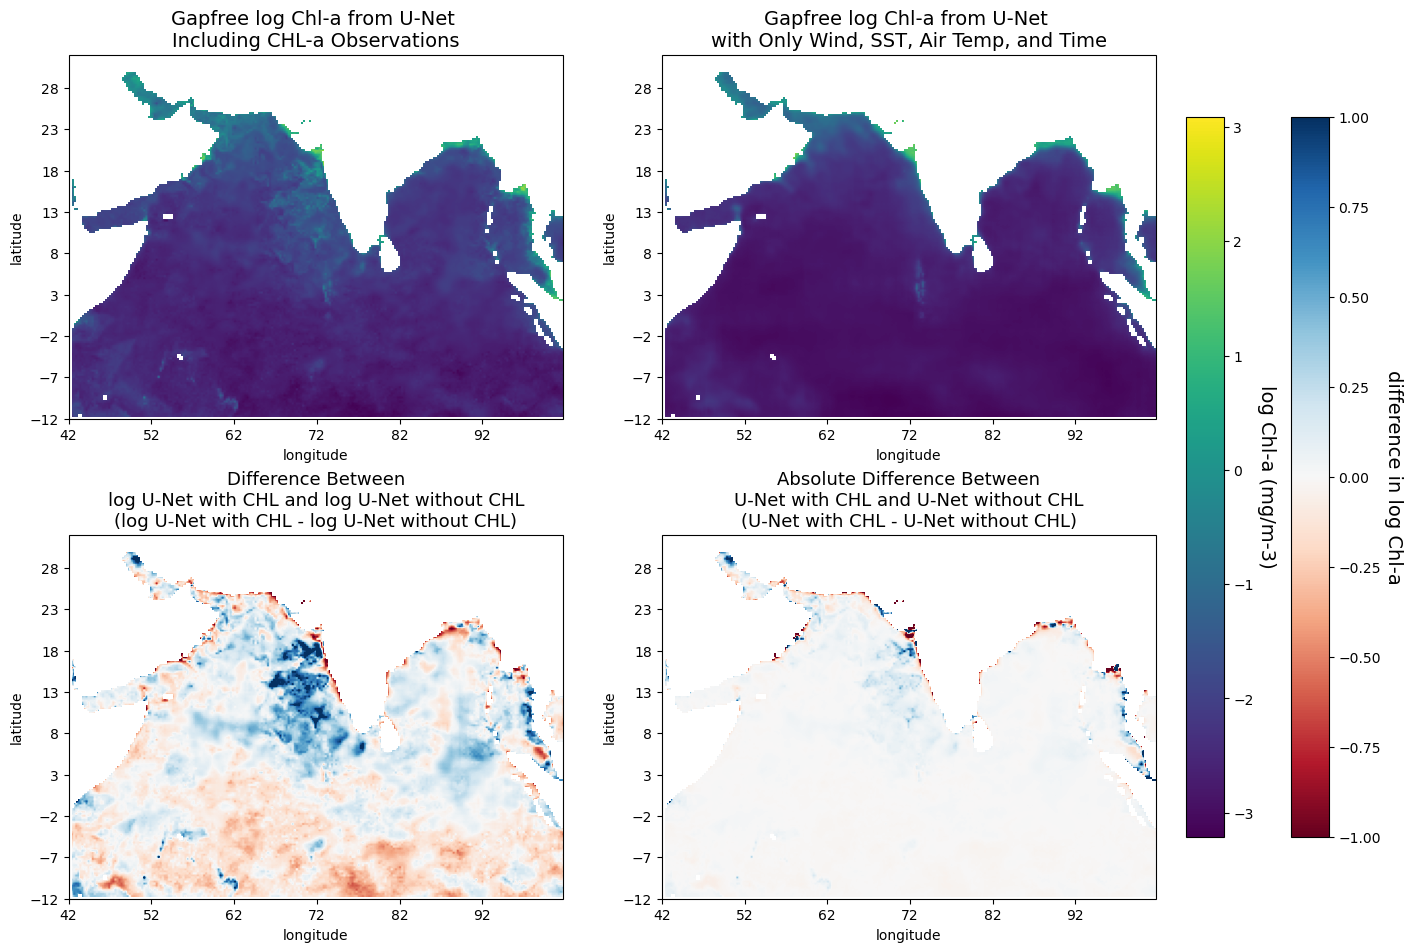

2020-04-26


In [102]:
compare_UNet(min_date)
print(min_date)

In [78]:
def comp_UNets_loss_unlog(year):
    zarr_pred_CHL = xr.open_zarr(zarr.DirectoryStore(f'../shared/yifei_data/{'U-Net_with_CHL_pred'}.zarr'))
    zarr_pred_no_CHL = xr.open_zarr(zarr.DirectoryStore(f'../shared/yifei_data/{'U-Net_without_CHL_pred'}.zarr'))
    
    pred_w_CHL = zarr_pred_CHL.sel(time=str(year))['gapfree_pred'].to_numpy()
    pred_no_CHL = zarr_pred_no_CHL.sel(time=str(year))['gapfree_pred'].to_numpy()
    losses = []
    for true, pred in zip(pred_w_CHL, pred_no_CHL):
        losses.append(compute_mae(np.exp(true), np.exp(pred)))
    
    # fig, ax1 = plt.subplots()
    
    # color = 'tab:red'
    # ax1.set_xlabel('Month')
    # ax1.set_ylabel('MAD of log (Globcolour l4) - log (U-Net)', color=color)
    # ax1.plot(losses, color=color)
    # ax1.tick_params(axis='y', labelcolor=color)
    
    # ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
    
    # color = 'tab:blue'
    # ax2.set_ylabel('Cloud Percentage', color=color)  # we already handled the x-label with ax1
    # ax2.plot(cloud_perc, color=color)
    # ax2.tick_params(axis='y', labelcolor=color)

    plt.plot(losses)
    plt.xlabel('Month')
    plt.ylabel('MAD of log (U-Net w/ CHL) - \nlog (U-Net w/o CHL)')

    tick_pos = []
    tick_label = []
    total_day = 1
    tick_pos.append(total_day + 15)
    tick_label.append('1')
    for month in range(1, 12):
        total_day += calendar.monthrange(year, month)[1]
        plt.axvline(total_day, color='grey', alpha=0.3)
        tick_pos.append(total_day + 15)
        tick_label.append(str(month+1))
    plt.title(f'U-Net Predictions with CHL vs U-Net Predictions without CHL\nMAD Year {year}')
    plt.xlim(1, len(losses))
    plt.xticks(tick_pos, tick_label)
    
    # fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

    max_ind = losses.index(max(losses))
    min_ind = losses.index(min(losses))
    max_date = np.datetime64(f'{year}-01-01') + np.timedelta64(max_ind - 1)
    min_date = np.datetime64(f'{year}-01-01') + np.timedelta64(min_ind - 1)

    return (max_date, min_date)


In [116]:
min_loss = np.inf
max_loss = -np.inf
min_date = None
max_date = None

zarr_pred_CHL = xr.open_zarr(zarr.DirectoryStore(f'../shared/yifei_data/{'U-Net_with_CHL_pred'}.zarr'))
zarr_pred_no_CHL = xr.open_zarr(zarr.DirectoryStore(f'../shared/yifei_data/{'U-Net_without_CHL_pred'}.zarr'))

for year in range(1997, 2023):
    pred_w_CHL = zarr_pred_CHL.sel(time=str(year))['gapfree_pred'].to_numpy()
    pred_no_CHL = zarr_pred_no_CHL.sel(time=str(year))['gapfree_pred'].to_numpy()
    losses = []
    for true, pred in zip(pred_w_CHL, pred_no_CHL):
        losses.append(compute_mae(true, pred))
    if min(losses) < min_loss:
        min_ind = losses.index(min(losses))
        min_date = np.datetime64(f'{year}-01-01') + np.timedelta64(min_ind - 1)
    if max(losses) > max_loss:
        max_ind = losses.index(max(losses))
        max_date = np.datetime64(f'{year}-01-01') + np.timedelta64(max_ind - 1)

In [117]:
min_date

numpy.datetime64('2022-04-20')

In [118]:
max_date

numpy.datetime64('2022-12-30')

In [113]:
min_date

numpy.datetime64('2022-04-20')

In [115]:
max_date

numpy.datetime64('2022-02-05')

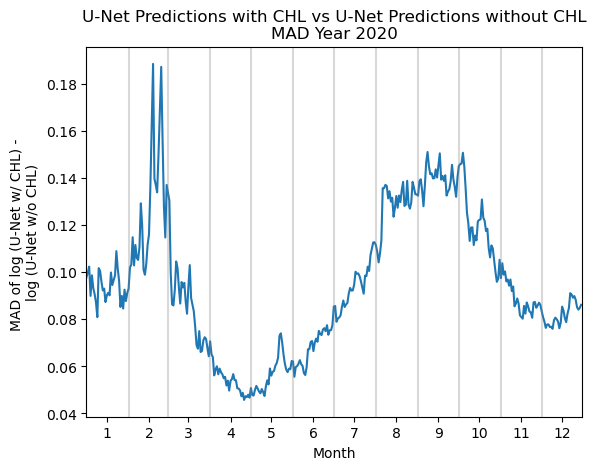

(numpy.datetime64('2020-02-19'), numpy.datetime64('2020-04-26'))

In [79]:
comp_UNets_loss_unlog(2020)

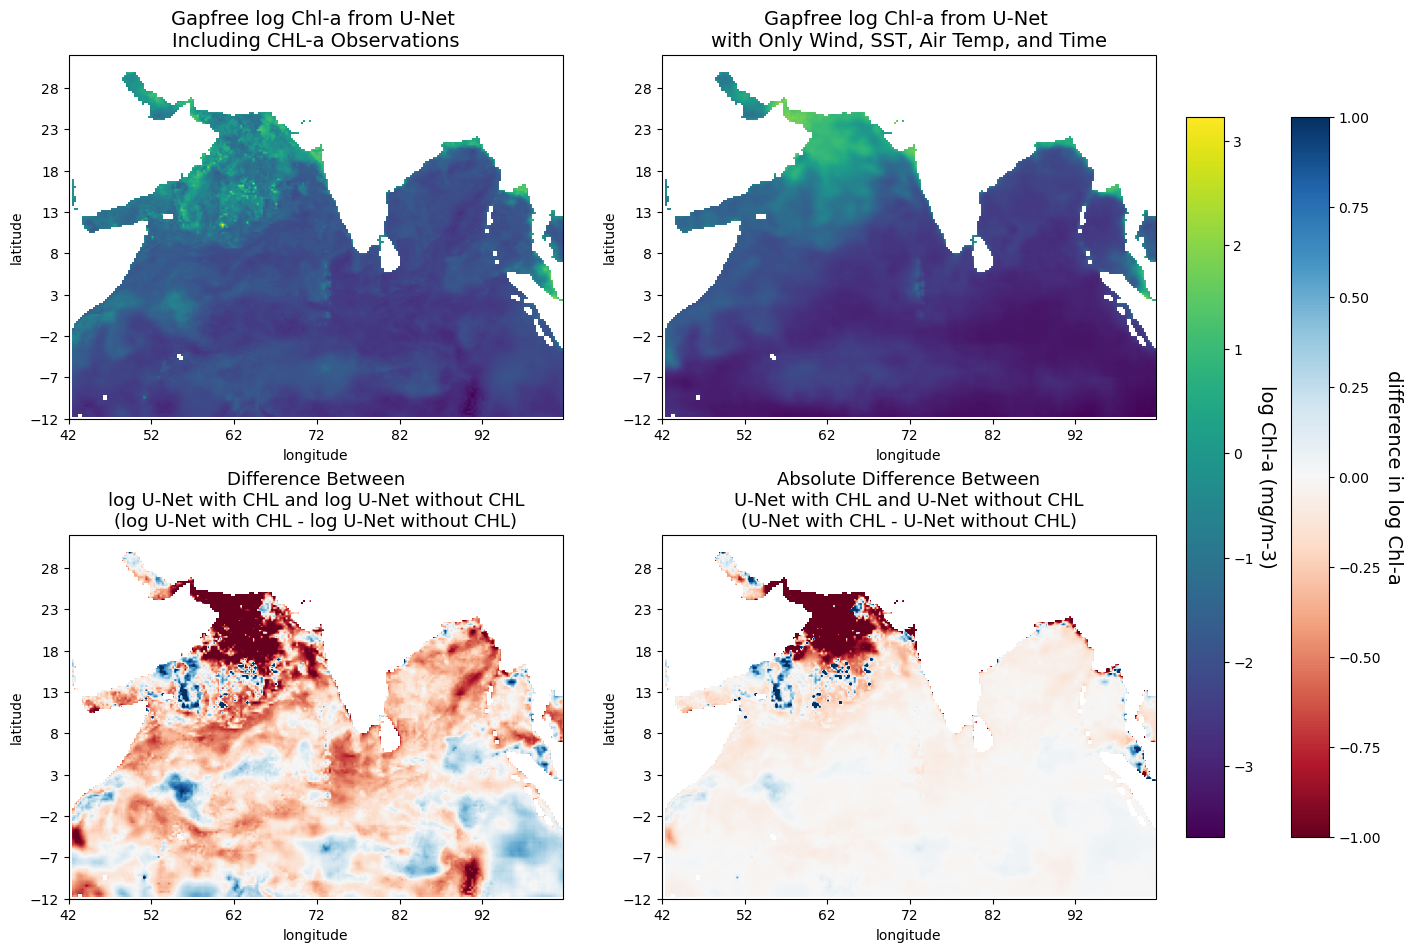

In [119]:
compare_UNet('2022-02-05')

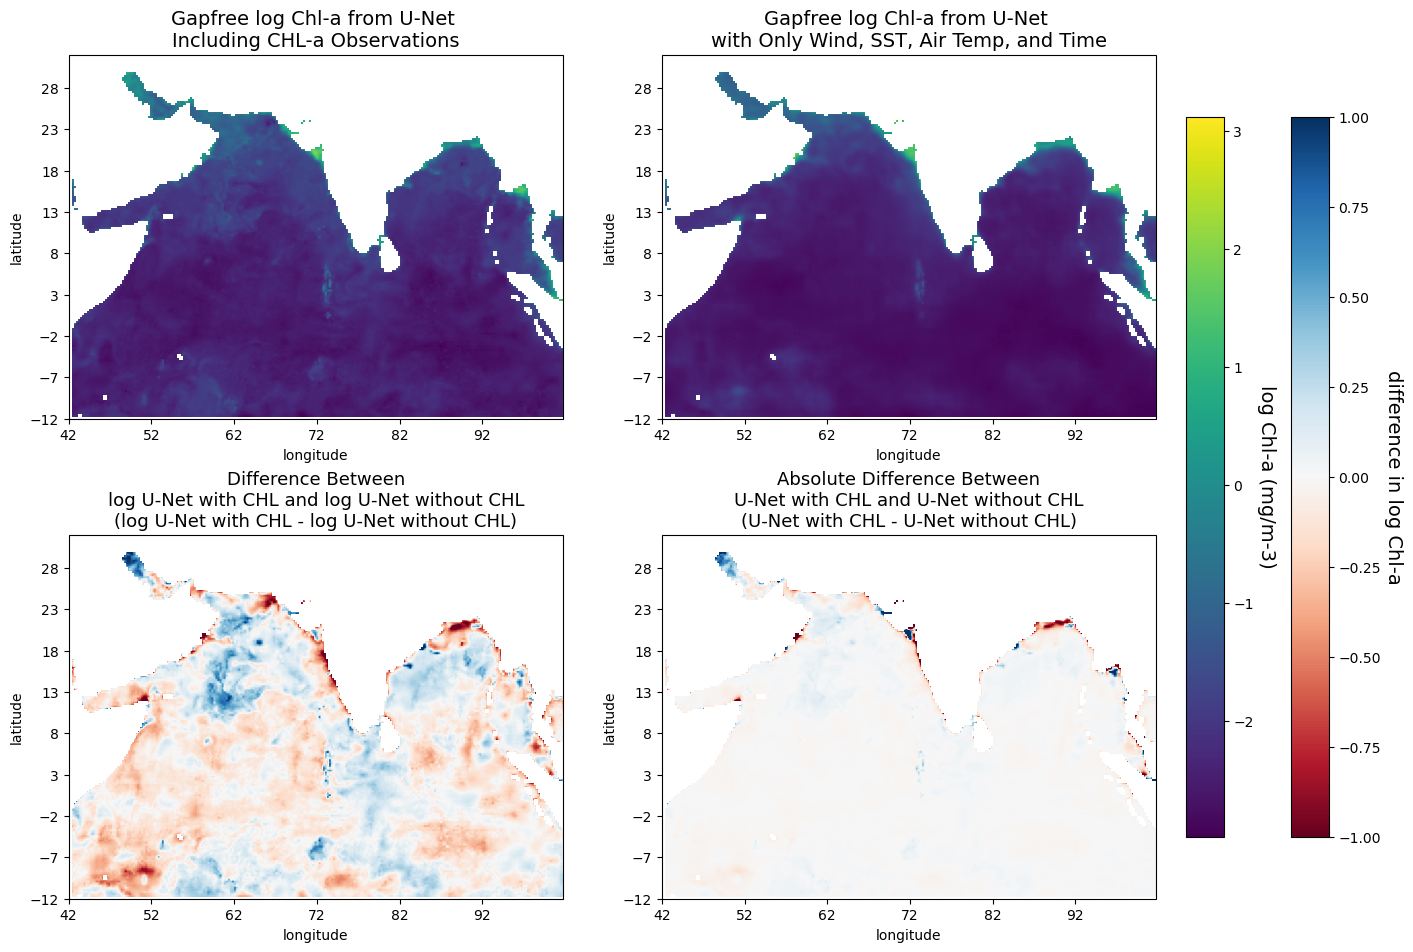

In [114]:
compare_UNet('2022-04-20')